In [41]:
"""
This notebook creates publication-quality visualizations of benchmark forecasts.
Supports both logistic and Harvey models with flexible styling options.
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from scipy import stats
from datetime import timedelta, date
import arviz as az
from scipy.stats import skewnorm
import pickle

# Set elegant style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['grid.alpha'] = 0.2

# Color palette - elegant and professional
BASE_COLOR = '#0e294c'      # Deep blue (main curves)
ACCENT_COLOR = '#d4af37'    # Gold (highlights)
GRAY_COLOR = '#6c757d'      # Gray (reference lines)
GRID_COLOR = "#5F86A5"      # Light blue (reference lines)
INTERVAL_COLORS = {
    'light': '#b8cfe0',     # Light blue (95% CI)
    'medium': '#7fa8c9',    # Medium blue (50% CI)
    'prediction': '#8b7f7b' # Light brown (prediction interval)
}

# CONFIG

In [42]:
# Default fit to use (can be changed)
DEFAULT_FIT = "harvey_joint_hyperparameters_all"  # Options:
# - "logistic_independent"
# - "logistic_joint_hyperparameters_all"
# - "harvey_independent"
# - "harvey_joint_hyperparameters_all"

DEFAULT_TOP_N = 3

# Available benchmarks (update this list based on your data)
INTERNAL_BENCHMARKS = [
    "FrontierMath",
    "FrontierMath Tier 4",
    "GPQA Diamond",
    "MATH Level 5",
    "OTIS Mock AIME 2024-2025",
    "SWE-Bench Verified",
    "SWE-Bench Bash Only"
]

EXTERNAL_BENCHMARKS = [
    "ARC-AGI",
    "ARC (AI2)",
    "Adversarial NLI",
    "Aider Polyglot",
    "AudioMultiChallenge",
    #"BIG-Bench Hard (BBH)",
    "BALROG",
    #"BoolQ",
    "CAD-Eval",
    #"CommonsenseQA 2.0",
    "Cybench",
    "DeepResearchBench",
    "EnigmaEval",
    "Factorio Learning Environment",
    "Fiction.LiveBench",
    "GeoBench", 
    "GSM8K",
    "GSO-Bench",
    "HellaSwag",
    "Humanity's Last Exam",
    #"LAMBADA",
    "Lech Mazur Writing",
    "LiveBench",
    "MCP Atlas",
    "METR Time Horizons",
    #"MMLU",
    "MultiChallenge",
    "MultiNRC",
    "OS World (Screenshot)",
    "OSUniverse",
    "OpenBookQA",
    "PIQA",
    "PRBench Finance",
    "PRBench Legal",
    "Remote Labor Index",
    "ScienceQA",
    "SimpleBench",
    #"SuperGLUE",
    "SWE-Bench Pro",
    "TerminalBench",
    "The Agent Company",
    #"ToolComp",
    #"TriviaQA",
    "TutorBench",
    "VPCT",
    #"Video-MME",
    "Visual Task Assessment (VISTA)",
    "VisualToolBench",
    "WeirdML",
    "WinoGrande",
]

ALL_BENCHMARKS = INTERNAL_BENCHMARKS + EXTERNAL_BENCHMARKS

# ---------------------------------------------------------
# Tier 3 – benchmarks that are clearly hard AND tightly 
# linked to loss-of-control risk: general AGI progress,
# advanced reasoning, critical SWE/ML automation, agentic
# research, and computer control.
# ---------------------------------------------------------

TIER3_CORE_AGI_PROGRESS = [
    "ARC-AGI",
    "LiveBench",        # reasoning, coding, mathematics, data analysis, and language
    # ARC-AGI II
    "Remote Labor Index",  # realistic set of real-world tasks
]

TIER3_HIGH_END_MATH_REASONING = [
    "FrontierMath",
    "FrontierMath Tier 4",
    "MATH Level 5",
    "OTIS Mock AIME 2024-2025",
]

TIER3_AUTONOMOUS_SWE = [
    "SWE-Bench Verified",  # real-world SWE issues
    "GSO-Bench",           # performance engineering
    "WeirdML",             # nonstandard ML engineering tasks
    "Aider Polyglot",      # cross-language programming problems (C++, Go, Java, JavaScript, Python, Rust)
    "SWE-Bench Pro",       # advanced software engineering tasks
    "SWE-Bench Bash Only",
    "METR Time Horizons"   # long-horizon coding tasks
]

TIER3_AGENTIC_COMPUTER_USE = [
    "Cybench",                  # security/CTF-style tasks
    "TerminalBench",            # agent using the terminal
    "OS World (Screenshot)",    # GUI computer use
    "OSUniverse",               # long-horizon OS tasks
    "The Agent Company",        # enterprise-style workflows
    "MCP Atlas"                 # multi-tool workflows
]

# ---------------------------------------------------------
# Tier 2 – important enablers but less critical
# ---------------------------------------------------------
TIER2_EXCLUDED = [
    "DeepResearchBench",    # search pages, interpret information
    #"SuperGLUE",            # advanced language understanding
    #"LAMBADA",              # long-range narrative understanding
]

TIER2_DOMAIN_SPECIFIC_QUESTIONS = [
    "GPQA Diamond",     # google-proof scientific questions
    #"MMLU",             # exam across humanities, STEM, social sciences, and professional domains
    "ARC (AI2)",        # grade-school science and math
    "GSM8K",            # basic math problems
    "ScienceQA",        # multimodal multiple-choice science questions
    "PRBench Finance",  # Professional Reasoning Benchmark - Finance
    "PRBench Legal",    # Professional Reasoning Benchmark - Legal
    "Humanity's Last Exam",
]

TIER2_GENERAL_REASONING = [
    #"BIG-Bench Hard (BBH)",         # compositional, symbolic, and multi-step reasoning
    "EnigmaEval",                   # long multimodal puzzles
    "BALROG",                       # challenging games
    "Adversarial NLI",              # textual reasoning under distribution shift
    "SimpleBench",                  # spatio-temporal reasoning, social intelligence, and trick questions
    "Factorio Learning Environment" # open-play setting requiring long-term planning
]

TIER2_MULTIMODAL_UNDERSTANDING = [
    #"Video-MME",                        # video-based understanding
    "AudioMultiChallenge",              # multi-turn audio conversations
    "VPCT",                             # visual physics comprehension (balls in buckets)
    "CAD-Eval",                         # generation of parametric 3D designs
    "VisualToolBench",                  # using tools to transform visual content
    "Visual Task Assessment (VISTA)",   # multidomain visual reasoning
    "GeoBench",                         # GeoGuessr
]

TIER2_ADVANCED_LANGUAGE_AND_WRITING = [
    "Fiction.LiveBench",    # long-context fiction comprehension
    "Lech Mazur Writing",   # writing-quality
    "MultiNRC",             # Multilingual Native Reasoning Challenge
    "MultiChallenge",       # multi-turn conversations
    "TutorBench",           # tutoring dialogues
]

# ---------------------------------------------------------
# Tier 1 – background QA / commonsense / basic reasoning
# ---------------------------------------------------------

TIER1_COMMONSENSE_QA = [
    #"BoolQ",                # reading comprehension benchmark
    #"CommonsenseQA 2.0",    # everyday commonsense questions
    "HellaSwag",            # commonsense sentence-completion
    "PIQA",                 # physical commonsense
    "WinoGrande",           # pronoun resolution and coreference
    #"TriviaQA",             # reading comprehension + commonsense reasoning
    "OpenBookQA",           # science statements + commonsense questions
]

# Functions

In [47]:
# ============================================================================
# Load lower bounds dictionary
# ============================================================================

def load_benchmark_lower_bounds(filepath: str = "benchmarks_lower_bounds.csv") -> dict:
    """
    Load benchmark lower bounds (random-chance baselines) from CSV.
    
    Returns:
        Dictionary mapping benchmark names to lower bound values (as floats)
    """
    lower_bounds = {}
    
    try:
        df = pd.read_csv(filepath, sep=';')
        
        for _, row in df.iterrows():
            if pd.isna(row['Benchmark']):
                continue
                
            benchmark_name = str(row['Benchmark']).strip()
            raw_val = row['Lower bound']
            
            if pd.isna(raw_val):
                lower_bounds[benchmark_name] = 0.0
                continue
            
            lower_bound_str = str(raw_val).strip().rstrip('%')
            lower_bound_str = lower_bound_str.replace(',', '.')
            
            if lower_bound_str.lower() in {'', 'nan', 'na', 'none', '-'}:
                lower_bounds[benchmark_name] = 0.0
                continue

            try:
                lower_bound_value = float(lower_bound_str) / 100
                lower_bounds[benchmark_name] = lower_bound_value
            except ValueError:
                lower_bounds[benchmark_name] = 0.0
        
        return lower_bounds
    
    except FileNotFoundError:
        print(f"Warning: Lower bounds file not found at {filepath}")
        return {}
    except Exception as e:
        print(f"Error loading lower bounds: {e}")
        return {}

# Load lower bounds globally
LOWER_BOUNDS_DICT = load_benchmark_lower_bounds("benchmarks_lower_bounds.csv")

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def simplify_benchmark_name(task_name: str) -> str:
    """
    Simplify benchmark names to their usual typography.
    
    Args:
        task_name: Full benchmark name
    
    Returns:
        Simplified name
    """
    # Mapping of full names to simplified versions
    name_map = {
        "FrontierMath": "FrontierMath",
        "FrontierMath Tier 4": "FrontierMath Tier 4",
        "GPQA Diamond": "GPQA Diamond",
        "MATH Level 5": "MATH Level 5",
        "OTIS Mock AIME 2024-2025": "AIME",
        "SWE-Bench Verified": "SWE-bench Verified",
    }
    
    return name_map.get(task_name, task_name)

_METADATA_CACHE = {} # Cache to avoid reloading data files multiple times

def load_fit_results(task_name, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N, 
                    load_dir='Fits', min_datapoints=5):
    """
    Load saved fit results for a benchmark.
    
    Args:
        task_name: name of the benchmark
        forecast_type: type of forecast model
        top_n: number of top models
        load_dir: directory containing saved fits
        min_datapoints: minimum number of datapoints required (default: 5)
    
    Returns:
        Dictionary with idata, frontier_df, and metadata
        
    Raises:
        ValueError: if the benchmark has fewer datapoints than min_datapoints
    """
    safe_task_name = task_name.replace('/', '_').replace(' ', '_').replace('.', '_')
    
    # Handle joint models differently
    if 'joint' in forecast_type:
        # Load joint model data
        idata_path = os.path.join(load_dir, f'joint_{forecast_type}_top{top_n}_idata.nc')
        frontier_csv_path = os.path.join(load_dir, 
                                        f'{safe_task_name}_{forecast_type}_top{top_n}_frontier.csv')
        
        idata = az.from_netcdf(idata_path)
        frontier_df = pd.read_csv(frontier_csv_path)
        
        # Find task index in joint model
        metadata_path = os.path.join(load_dir, f'joint_{forecast_type}_top{top_n}_metadata.pkl')
        if metadata_path not in _METADATA_CACHE:
            with open(metadata_path, 'rb') as f:
                _METADATA_CACHE[metadata_path] = pickle.load(f)
        metadata = _METADATA_CACHE[metadata_path]
        
        task_idx = metadata['task_names'].index(task_name)        
    else:
        # Load independent model data
        idata_path = os.path.join(load_dir, f'{safe_task_name}_{forecast_type}_top{top_n}_idata.nc')
        frontier_csv_path = os.path.join(load_dir, 
                                        f'{safe_task_name}_{forecast_type}_top{top_n}_frontier.csv')
        
        idata = az.from_netcdf(idata_path)
        frontier_df = pd.read_csv(frontier_csv_path)
        task_idx = None
    
    # Convert date columns
    frontier_df['date'] = pd.to_datetime(frontier_df['date']).dt.date
    if 'date_dt' in frontier_df.columns:
        frontier_df['date_dt'] = pd.to_datetime(frontier_df['date_dt'])
    
    # Check minimum datapoints requirement
    n_datapoints = len(frontier_df)
    if n_datapoints < min_datapoints:
        raise ValueError(
            f"Benchmark '{task_name}' has only {n_datapoints} datapoints, "
            f"but minimum required is {min_datapoints}"
        )
    
    return {
        'idata': idata,
        'frontier_df': frontier_df,
        'task_name': task_name,
        'task_idx': task_idx,
        'forecast_type': forecast_type,
        'top_n': top_n,
        'n_datapoints': n_datapoints
    }

def compute_predictions(fit_results, forecast_days=None, lower_bound=0.0):
    """
    Compute predictions from fit results (vectorized version).
    
    Args:
        fit_results: dict from load_fit_results()
        forecast_days: days to forecast beyond last observation (if None, forecast to 2030)
        lower_bound: lower asymptote
    
    Returns:
        Dictionary with predictions, dates, and uncertainty bands
    """
    idata = fit_results['idata']
    frontier_df = fit_results['frontier_df']
    task_idx = fit_results['task_idx']
    forecast_type = fit_results['forecast_type']
    
    # Calculate forecast_days to reach 2030 if not specified
    if forecast_days is None:
        last_date = frontier_df['date'].max()
        target_date = date(2030, 1, 1)
        forecast_days = (target_date - last_date).days
    
    posterior = idata.posterior
    
    # Extract parameters (handle joint vs independent)
    if task_idx is not None:
        # Joint model
        L_samples = posterior['L'].sel(L_dim_0=task_idx).values.flatten()
        xi_base_samples = posterior['xi_base'].sel(xi_base_dim_0=task_idx).values.flatten()
        s_samples = posterior['s'].sel(s_dim_0=task_idx).values.flatten()
        
        if 'harvey' in forecast_type:
            k_samples = posterior['k'].sel(k_dim_0=task_idx).values.flatten()
            t0_samples = posterior['t0'].sel(t0_dim_0=task_idx).values.flatten()
            alpha_samples = posterior['alpha'].sel(alpha_dim_0=task_idx).values.flatten()
        else:
            k_samples = posterior['k'].sel(k_dim_0=task_idx).values.flatten()
            t0_samples = posterior['t0'].sel(t0_dim_0=task_idx).values.flatten()
    else:
        # Independent model
        L_samples = posterior['L'].values.flatten()
        xi_base_samples = posterior['xi_base'].values.flatten()
        s_samples = posterior['s'].values.flatten()
        
        if 'harvey' in forecast_type:
            k_samples = posterior['k'].values.flatten()
            t0_samples = posterior['t0'].values.flatten()
            alpha_samples = posterior['alpha_shifted'].values.flatten()
        else:
            k_samples = posterior['k'].values.flatten()
            t0_samples = posterior['t0'].values.flatten()
    
    # Time grid
    t_obs = frontier_df['days'].values
    t_min = t_obs.min()
    t_max = t_obs.max() + forecast_days
    t_grid = np.linspace(t_min, t_max, 200)
    
    n_samples = len(L_samples)
    n_time = len(t_grid)
    
    # Reshape for broadcasting: (n_samples, 1) and (1, n_time) -> (n_samples, n_time)
    L = L_samples[:, np.newaxis]                    # (n_samples, 1)
    xi_base = xi_base_samples[:, np.newaxis]        # (n_samples, 1)
    t = t_grid[np.newaxis, :]                       # (1, n_time)
    
    # Compute curve_01 vectorized
    if 'harvey' in forecast_type:
        # Harvey curve - fully vectorized
        k = k_samples[:, np.newaxis]                # (n_samples, 1)
        t0 = t0_samples[:, np.newaxis]              # (n_samples, 1)
        alpha = alpha_samples[:, np.newaxis]        # (n_samples, 1)
        
        exponent = -k * (t - t0)                    # (n_samples, n_time)
        base = 1 - (1 - alpha) * np.exp(exponent)   # (n_samples, n_time)
        base = np.maximum(base, 1e-10)              # Avoid numerical issues
        curve_01 = np.power(base, 1 / (1 - alpha))  # (n_samples, n_time)
    else:
        # Logistic curve - fully vectorized
        k = k_samples[:, np.newaxis]                # (n_samples, 1)
        t0 = t0_samples[:, np.newaxis]              # (n_samples, 1)
        
        curve_01 = 1.0 / (1 + np.exp(-k * (t - t0)))  # (n_samples, n_time)
    
    # Compute predictions: mu = lower_bound + (L - lower_bound) * curve_01
    predictions = lower_bound + (L - lower_bound) * curve_01  # (n_samples, n_time)
    
    # Compute heteroskedastic noise vectorized
    variance_shape = np.sqrt((predictions - lower_bound) * (L - predictions))
    max_variance = (L - lower_bound) / 2.0
    noise_factor = variance_shape / np.maximum(max_variance, 1e-10)  # Avoid division by zero
    xi_grid = 0.01 + xi_base * noise_factor  # (n_samples, n_time)
    
    # Compute prediction intervals using vectorized sampling
    subsample_step = 5
    subsample_idx = np.arange(0, n_samples, subsample_step)
    n_subsamples = len(subsample_idx)
    samples_per_point = 5
    
    # Extract subsampled arrays
    mu_sub = predictions[subsample_idx, :]           # (n_subsamples, n_time)
    xi_sub = xi_grid[subsample_idx, :]     # (n_subsamples, n_time)
    s_sub = s_samples[subsample_idx]  # (n_subsamples,)
    
    # Generate all random samples at once
    # For skewnorm, we need to generate samples for each (subsample, time) pair
    # Shape: (n_subsamples, n_time, samples_per_point)
    
    # Generate standard skewnorm samples and transform
    # skewnorm.rvs can be vectorized with broadcasting
    all_samples = np.zeros((n_subsamples, n_time, samples_per_point))
    
    for i, idx in enumerate(subsample_idx):
        # Generate samples for all time points at once for this subsample
        # skewnorm.rvs with array loc and scale
        samples = skewnorm.rvs(
            s_samples[idx],
            loc=mu_sub[i, :, np.newaxis],      # (n_time, 1)
            scale=xi_sub[i, :, np.newaxis],  # (n_time, 1)
            size=(n_time, samples_per_point)
        )
        all_samples[i] = samples
    
    # Reshape and clip
    all_samples = np.clip(all_samples, 0, 1)  # (n_subsamples, n_time, samples_per_point)
    
    # Compute percentiles across subsamples and samples_per_point dimensions
    # Reshape to (n_subsamples * samples_per_point, n_time)
    all_samples_flat = all_samples.transpose(1, 0, 2).reshape(n_time, -1)  # (n_time, n_subsamples * samples_per_point)
    
    lower_sampling = np.percentile(all_samples_flat, 2.5, axis=1)
    upper_sampling = np.percentile(all_samples_flat, 97.5, axis=1)
    
    # Convert to dates
    min_date = frontier_df['date'].min()
    dates_grid = [min_date + timedelta(days=int(d)) for d in t_grid]
    
    return {
        'dates': dates_grid,
        't_grid': t_grid,
        'predictions': predictions,
        'median': np.percentile(predictions, 50, axis=0),
        'lower_50': np.percentile(predictions, 25, axis=0),
        'upper_50': np.percentile(predictions, 75, axis=0),
        'lower_80': np.percentile(predictions, 10, axis=0),
        'upper_80': np.percentile(predictions, 90, axis=0),
        'lower_95': np.percentile(predictions, 2.5, axis=0),
        'upper_95': np.percentile(predictions, 97.5, axis=0),
        'lower_sampling': lower_sampling,
        'upper_sampling': upper_sampling
    }

# ============================================================================
# IMPROVED PLOTTING FUNCTIONS
# ============================================================================

def plot_single_benchmark(task_name, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N,
                         forecast_days=None, lower_bound=None,
                         ci_level=95, show_prediction_interval=True,
                         figsize=(10, 5), save_path=None):
    """
    Create an elegant plot for a single benchmark with simplified name.
    
    Args:
        task_name: name of the benchmark
        forecast_type: type of forecast model
        top_n: number of top models
        forecast_days: days to forecast (None = forecast to 2030)
        lower_bound: random chance baseline (if None, auto-load from LOWER_BOUNDS_DICT)
        ci_level: credible interval level (50, 80, or 95)
        show_prediction_interval: whether to show prediction interval
        figsize: figure size
        save_path: path to save figure (None = don't save)
    """
    # Auto-load lower bound if not provided
    if lower_bound is None:
        lower_bound = LOWER_BOUNDS_DICT.get(task_name, 0.0)
    
    # Simplify name for display
    display_name = simplify_benchmark_name(task_name)
    
    # Load fit results
    fit_results = load_fit_results(task_name, forecast_type, top_n)
    frontier_df = fit_results['frontier_df']
    
    # Compute predictions WITH lower bound
    pred = compute_predictions(fit_results, forecast_days, lower_bound)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')
    
    # Reference line for lower bound (improved styling)
    if lower_bound > 0.01:
        ax.axhline(lower_bound, color=GRAY_COLOR, linestyle=':', 
                  alpha=0.5, linewidth=1.5, zorder=1)
        # Add label above the line
        ax.text(pred['dates'][len(pred['dates']) // 2], lower_bound + 0.01,
                'Random chance', fontsize=10, color=GRAY_COLOR, alpha=0.8,
                verticalalignment='bottom', horizontalalignment='left')
    
    # Prediction interval (if requested)
    if show_prediction_interval:
        ax.fill_between(pred['dates'], pred['lower_sampling'], pred['upper_sampling'],
                       alpha=0.15, color=INTERVAL_COLORS['prediction'], 
                       label='95% prediction interval', zorder=2)
    
    # Credible intervals
    if ci_level == 95:
        ax.fill_between(pred['dates'], pred['lower_95'], pred['upper_95'],
                       alpha=0.2, color=INTERVAL_COLORS['light'],
                       label='95% credible interval', zorder=3)
    if ci_level == 80:
        ax.fill_between(pred['dates'], pred['lower_80'], pred['upper_80'],
                       alpha=0.3, color=INTERVAL_COLORS['medium'],
                       label='80% credible interval', zorder=4)
    if ci_level == 50:
        ax.fill_between(pred['dates'], pred['lower_50'], pred['upper_50'],
                       alpha=0.4, color=BASE_COLOR, linewidth=0,
                       label='50% credible interval', zorder=5)
    
    # Find last observation date to split line
    last_obs_date = frontier_df['date'].max()
    
    # Split prediction into observed and forecast periods
    obs_mask = [d <= last_obs_date for d in pred['dates']]
    forecast_mask = [d >= last_obs_date for d in pred['dates']]
    
    # Median prediction - solid line for observed period
    ax.plot([d for d, m in zip(pred['dates'], obs_mask) if m], 
           [p for p, m in zip(pred['median'], obs_mask) if m],
           '-', linewidth=1.5, color=BASE_COLOR, label='Median forecast', zorder=6)
    
    # Median prediction - dashed line for forecast period
    ax.plot([d for d, m in zip(pred['dates'], forecast_mask) if m],
           [p for p, m in zip(pred['median'], forecast_mask) if m],
           linestyle=(5, (4, 2)), alpha=0.2, linewidth=1.5, color=BASE_COLOR, zorder=6)
    
    # Observed data points with transparency
    if top_n == 1:
        ax.scatter(frontier_df['date'], frontier_df['score'], 
                  s=80, color=ACCENT_COLOR, edgecolors='white', linewidth=1.5,
                  label='Observed frontier', zorder=10, alpha=0.7)
    else:
        # Blue gradient for ranks
        rank_colors = plt.cm.Blues(np.linspace(0.9, 0.2, top_n))
        for rank in range(1, top_n + 1):
            rank_data = frontier_df[frontier_df['rank'] == rank]
            if not rank_data.empty:
                ax.scatter(rank_data['date'], rank_data['score'],
                         s=100 - (rank-1)*10, color=rank_colors[rank-1],
                         edgecolors='white', linewidth=1.5,
                         label=f'Top-{rank} at release', 
                         alpha=0.65, zorder=10-rank)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=13, fontweight='500', color=BASE_COLOR)
    ax.set_ylabel('Performance', fontsize=13, fontweight='500', color=BASE_COLOR)
    
    # Title with simplified name
    model_name = 'de Harvey' if 'harvey' in forecast_type else 'Logistique'
    hierarchy = 'Joint' if 'joint' in forecast_type else 'Indépendant'
    title_suffix = f" (Frontière)" if top_n == 1 else f" (Top-{top_n})"
    ax.set_title(f'{display_name}{title_suffix}', 
                fontsize=15, fontweight='600', color=BASE_COLOR, pad=15)
    
    # Subtle subtitle
    ax.text(0.5, 0.99, f'Modèle de croissance {model_name} ({hierarchy})',
        transform=ax.transAxes, ha='center', va='bottom',
        fontsize=10, color=GRAY_COLOR, style='italic')    
    
    # Grid and spines
    ax.grid(True, alpha=0.1, linewidth=0.8, color=GRID_COLOR)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color(BASE_COLOR)
    
    # Format Y-axis as percentage without axis line
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
    ax.tick_params(axis='y', left=False, right=False)
    ax.tick_params(labelsize=8, colors=BASE_COLOR)
    
    # Legend
    legend = ax.legend(loc='lower right', fontsize=9, framealpha=0.95,
             edgecolor=BASE_COLOR, fancybox=True)
    for text in legend.get_texts():
        text.set_color(BASE_COLOR)

    # Y-axis limits (account for lower bound)
    ax.set_ylim(-0.02, 1.05)
    
    # X-axis formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='none', transparent=True)
        print(f"Saved plot to: {save_path}")
    
    plt.show()

def plot_benchmark_comparison(task_names, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N,
                              forecast_days=None, lower_bounds=None,
                              ci_level=80, show_prediction_interval=False,
                              figsize=(10, 5), save_path=None,
                              category_name=None):
    """
    Plot multiple benchmarks on the same graph for comparison.
    Uses elegant color palette with benchmarks sorted by performance.
    
    Args:
        task_names: list of benchmark names
        forecast_type: type of forecast model
        top_n: number of top models
        forecast_days: days to forecast (None = forecast to 2030)
        lower_bounds: dict of {task_name: lower_bound} (if None, auto-load)
        ci_level: credible interval level
        show_prediction_interval: whether to show prediction intervals
        figsize: figure size
        save_path: path to save figure
        category_name: optional category name for title (e.g., 'High-End Math Reasoning')
        tier: optional tier number (1, 2, or 3) for title
    """
    # Auto-load lower bounds if not provided
    if lower_bounds is None:
        lower_bounds = {name: LOWER_BOUNDS_DICT.get(name, 0.0) for name in task_names}
    
    # Elegant color palette
    elegant_colors = [
        '#1f4788',  # Royal blue (deep, saturated)
        '#4a7c59',  # Forest green-blue
        '#457b9d',  # Steel blue (medium blue)
        '#8b7f7b',  # Warm gray (neutral)
        '#264653',  # Dark slate (near black-blue)
        '#6a4c93',  # Purple (cool contrast)
        '#e76f51',  # Terracotta (warm contrast)
        '#06aed5',  # Bright cyan (vivid cool)
        '#f4a261',  # Sandy orange (soft warm)
        '#2a9d8f',  # Teal (distinctive green-blue)
    ]    
    
    # Compute 2026 predictions for sorting
    target_date = date(2026, 1, 1)
    benchmark_predictions = {}
    benchmark_data = {}
    
    for task_name in task_names:
        lower_bound = lower_bounds.get(task_name, 0.0)
        
        try:
            fit_results = load_fit_results(task_name, forecast_type, top_n)
            frontier_df = fit_results['frontier_df']
            pred = compute_predictions(fit_results, forecast_days, lower_bound)
            
            # Find prediction at 2026-01-01
            date_diffs = [abs((d - target_date).days) for d in pred['dates']]
            closest_idx = np.argmin(date_diffs)
            prediction_2026 = pred['median'][closest_idx]
            
            benchmark_predictions[task_name] = prediction_2026
            benchmark_data[task_name] = {
                'frontier_df': frontier_df,
                'pred': pred,
            }
            
        except Exception as e:
            print(f"Error loading {task_name}: {e}")
            benchmark_predictions[task_name] = -1
    
    # Sort by 2026 prediction (descending)
    sorted_task_names = sorted(task_names, 
                               key=lambda x: benchmark_predictions.get(x, -1), 
                               reverse=True)
    
    n_tasks = len(sorted_task_names)
    colors = elegant_colors[:n_tasks] if n_tasks <= len(elegant_colors) else elegant_colors * ((n_tasks // len(elegant_colors)) + 1)
    
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')
    
    for i, task_name in enumerate(sorted_task_names):
        if task_name not in benchmark_data:
            continue
            
        color = colors[i]
        data = benchmark_data[task_name]
        frontier_df = data['frontier_df']
        pred = data['pred']
        
        # Simplify name for display
        display_name = simplify_benchmark_name(task_name)
        
        # Find last observation date
        last_obs_date = frontier_df['date'].max()
        obs_mask = [d <= last_obs_date for d in pred['dates']]
        forecast_mask = [d >= last_obs_date for d in pred['dates']]
        
        # Plot CI with matching color
        if ci_level == 80:
            ax.fill_between(pred['dates'], pred['lower_80'], pred['upper_80'],
                           alpha=0.2, color=color, linewidth=0)
        elif ci_level == 95:
            ax.fill_between(pred['dates'], pred['lower_95'], pred['upper_95'],
                           alpha=0.2, color=color, linewidth=0)
        
        # Median line - solid for observed period
        ax.plot([d for d, m in zip(pred['dates'], obs_mask) if m],
               [p for p, m in zip(pred['median'], obs_mask) if m],
               '-', linewidth=1.5, color=color, alpha=0.8, zorder=6)
        
        # Median line - dashed for forecast period
        ax.plot([d for d, m in zip(pred['dates'], forecast_mask) if m],
               [p for p, m in zip(pred['median'], forecast_mask) if m], linestyle=(5, (4, 2)), 
               linewidth=1.5, color=color, label=display_name, alpha=0.5, zorder=6)
        
        # Observations with transparency
        ax.scatter(frontier_df['date'], frontier_df['score'],
                  s=40, color=color, marker='o', edgecolors='white', 
                  alpha=0.4, zorder=5)
    
    # Formatting
    ax.set_xlabel('', fontsize=13, fontweight='500', color=BASE_COLOR)
    ax.set_ylabel('Performance', fontsize=13, fontweight='500', color=BASE_COLOR)
    
    # Build title based on whether category info is provided
    model_name = 'de Harvey' if 'harvey' in forecast_type else 'Logistique'
    
    if category_name:
        # Title with category
        title = f'{category_name}'
        subtitle = f'Modèle {model_name}'
    else:
        # Default title (backward compatible)
        title = f'Comparaison de benchmarks (Modèle {model_name})'
        subtitle = None
        
    ax.set_title(title, fontsize=13, fontweight='600', color=BASE_COLOR, 
                pad=20 if subtitle else 15)
    
    # Add subtitle if present
    if subtitle:
        ax.text(0.5, 1.01, subtitle,
               transform=ax.transAxes, ha='center', va='bottom',
               fontsize=10, color=GRAY_COLOR, style='italic')
    
    ax.grid(True, alpha=0.1, linewidth=0.8, color=GRID_COLOR)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color(BASE_COLOR)
    
    # Format Y-axis as percentage without axis line
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
    ax.tick_params(axis='y', left=False, right=False)
    ax.tick_params(labelsize=8, colors=BASE_COLOR)
    
    # Legend with benchmarks sorted by performance (highest first)
    legend = ax.legend(loc='lower right', fontsize=10, framealpha=0.95,
                       edgecolor=BASE_COLOR, fancybox=True, ncol=1)
    for text in legend.get_texts():
        text.set_color(BASE_COLOR)
    
    # Increase line width in legend and remove dashed lines
    for line in legend.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle('-')
    
    # Y-axis limits
    ax.set_ylim(-0.02, 1.05)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='none', transparent=True)
        print(f"Saved plot to: {save_path}")
    
    plt.show()

def plot_benchmark_grid(task_names, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N,
                       forecast_days=None, lower_bounds=None,
                       ci_level=80, show_prediction_interval=False,
                       ncols=3, subplot_size=(4, 3), save_path=None):
    """
    Plot multiple benchmarks in a grid layout with simplified names.
    
    Args:
        task_names: list of benchmark names
        forecast_type: type of forecast model
        top_n: number of top models
        forecast_days: days to forecast (None = forecast to 2030)
        lower_bounds: dict of {task_name: lower_bound} (if None, auto-load)
        ci_level: credible interval level
        show_prediction_interval: whether to show prediction intervals
        ncols: number of columns in grid
        subplot_size: size of each subplot (width, height)
        save_path: path to save figure
    """
    # Auto-load lower bounds if not provided
    if lower_bounds is None:
        lower_bounds = {name: LOWER_BOUNDS_DICT.get(name, 0.0) for name in task_names}
    
    n_tasks = len(task_names)
    nrows = int(np.ceil(n_tasks / ncols))
    
    fig = plt.figure(figsize=(subplot_size[0] * ncols, subplot_size[1] * nrows),
                    facecolor='white')
    gs = GridSpec(nrows, ncols, figure=fig, hspace=0.4, wspace=0.3)
    
    for idx, task_name in enumerate(task_names):
        row = idx // ncols
        col = idx % ncols
        ax = fig.add_subplot(gs[row, col])
        
        lower_bound = lower_bounds.get(task_name, 0.0)
        display_name = simplify_benchmark_name(task_name)
        
        # Load and compute
        try:
            fit_results = load_fit_results(task_name, forecast_type, top_n)
            frontier_df = fit_results['frontier_df']
            pred = compute_predictions(fit_results, forecast_days, lower_bound)
            
            # Lower bound line (subtle)
            if lower_bound > 0.01:
                ax.axhline(lower_bound, color=GRAY_COLOR, linestyle=':', 
                          alpha=0.4, linewidth=1)
            
            # Credible interval
            if ci_level == 80:
                ax.fill_between(pred['dates'], pred['lower_80'], pred['upper_80'],
                               alpha=0.2, color=INTERVAL_COLORS['medium'])
            elif ci_level == 95:
                ax.fill_between(pred['dates'], pred['lower_95'], pred['upper_95'],
                               alpha=0.2, color=INTERVAL_COLORS['light'])
            
            # Median
            ax.plot(pred['dates'], pred['median'], '-', linewidth=2,
                   color=BASE_COLOR)
            
            # Observations
            ax.scatter(frontier_df['date'], frontier_df['score'],
                      s=40, color=ACCENT_COLOR, edgecolors='white', 
                      linewidth=1, alpha=0.8, zorder=5)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{display_name}',
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=9, color='red')
            print(f"Error loading {task_name}: {e}")
        
        # Formatting with simplified name
        ax.set_title(display_name, fontsize=10, fontweight='600', 
                    color=BASE_COLOR, pad=8)
        ax.grid(True, alpha=0.3, linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color(BASE_COLOR)
        
        # Format Y-axis as percentage without axis line
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
        ax.tick_params(axis='y', left=False, right=False)
        
        # Y-axis limits (account for lower bound)
        ax.set_ylim(-0.02, 1.05)
        
        # Axis labels only on edges
        if row == nrows - 1:
            ax.set_xlabel('Year', fontsize=9, color=BASE_COLOR)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_major_locator(mdates.YearLocator(2))
        else:
            ax.set_xticklabels([])
        
        if col == 0:
            ax.set_ylabel('Score', fontsize=9, color=BASE_COLOR)
        else:
            ax.set_yticklabels([])
        
        ax.tick_params(labelsize=8, colors=BASE_COLOR)
    
    # Overall title
    model_name = 'Harvey' if 'harvey' in forecast_type else 'Logistic'
    fig.suptitle(f'Benchmark Forecasts ({model_name} Model)', 
                fontsize=16, fontweight='600', color=BASE_COLOR, y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='none', transparent=True)
        print(f"Saved plot to: {save_path}")
    
    plt.show()


In [48]:
def get_benchmark_datapoint_counts(task_names, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N):
    """
    Get the number of datapoints for each benchmark.
    
    Args:
        task_names: list of benchmark names
        forecast_type: type of forecast model
        top_n: number of top models
    
    Returns:
        Dictionary mapping benchmark names to datapoint counts
    """
    datapoint_counts = {}
    
    for task_name in task_names:
        try:
            fit_results = load_fit_results(task_name, forecast_type, top_n, min_datapoints=1)
            datapoint_counts[task_name] = fit_results['n_datapoints']
        except Exception as e:
            print(f"Error loading {task_name}: {e}")
            datapoint_counts[task_name] = 0
    
    return datapoint_counts

def print_benchmark_datapoint_summary(task_names, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N):
    """
    Print a summary of datapoint counts for all benchmarks.
    
    Args:
        task_names: list of benchmark names
        forecast_type: type of forecast model
        top_n: number of top models
    """
    counts = get_benchmark_datapoint_counts(task_names, forecast_type, top_n)
    
    print(f"\n{'='*70}")
    print(f"BENCHMARK DATAPOINT SUMMARY")
    print(f"{'='*70}\n")
    
    # Sort by count (descending)
    sorted_benchmarks = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    for task_name, count in sorted_benchmarks:
        display_name = simplify_benchmark_name(task_name)
        print(f"  {display_name:<40} : {count:3d} datapoints")
    
    print(f"\n{'-'*70}")
    print(f"  Total benchmarks: {len(counts)}")
    print(f"  Average datapoints: {np.mean(list(counts.values())):.1f}")
    print(f"  Min datapoints: {min(counts.values())}")
    print(f"  Max datapoints: {max(counts.values())}")
    print(f"{'='*70}\n")
    
    return counts

counts = print_benchmark_datapoint_summary(
    ALL_BENCHMARKS,
    forecast_type="harvey_joint_hyperparameters_all",
    top_n=3
)


BENCHMARK DATAPOINT SUMMARY

  AIME                                     :  39 datapoints
  GPQA Diamond                             :  36 datapoints
  MATH Level 5                             :  30 datapoints
  FrontierMath Tier 4                      :  23 datapoints
  ARC (AI2)                                :  23 datapoints
  MultiChallenge                           :  23 datapoints
  PIQA                                     :  23 datapoints
  WeirdML                                  :  23 datapoints
  Aider Polyglot                           :  22 datapoints
  FrontierMath                             :  21 datapoints
  LiveBench                                :  21 datapoints
  METR Time Horizons                       :  21 datapoints
  ARC-AGI                                  :  20 datapoints
  HellaSwag                                :  20 datapoints
  ScienceQA                                :  20 datapoints
  Fiction.LiveBench                        :  19 datapoints
  Visual T

In [49]:
# ============================================================================
# CHECK AVAILABLE BENCHMARKS AND TIER COVERAGE
# ============================================================================

def get_all_available_benchmarks(load_dir='Fits', forecast_type="harvey_joint_hyperparameters_all", top_n=3):
    """Find all benchmarks with forecast files. Returns safe names from files."""
    pattern = re.compile(rf'^(.+)_{forecast_type}_top{top_n}_frontier\.csv$')
    return sorted([m.group(1) for f in os.listdir(load_dir) if (m := pattern.match(f))])

# Build mappings
available_safe = get_all_available_benchmarks()
safe_to_original = {name.replace('/', '_').replace(' ', '_').replace('.', '_'): name 
                    for name in ALL_BENCHMARKS}

# Check file availability
print("="*70)
print("BENCHMARKS WITH AVAILABLE FORECASTS")
print("="*70)
print(f"\nFound {len(available_safe)} benchmarks\n")

in_files_not_in_list = set(available_safe) - set(safe_to_original.keys())
in_list_not_in_files = set(safe_to_original.keys()) - set(available_safe)

if in_files_not_in_list:
    print(f"⚠️  In files but NOT in ALL_BENCHMARKS ({len(in_files_not_in_list)}):")
    for b in sorted(in_files_not_in_list):
        print(f"    - {b}")

if in_list_not_in_files:
    print(f"\n⚠️  In ALL_BENCHMARKS but NO forecast file ({len(in_list_not_in_files)}):")
    for b in sorted(in_list_not_in_files):
        print(f"    - {safe_to_original.get(b, b)}")

if not in_files_not_in_list and not in_list_not_in_files:
    print("✅ ALL_BENCHMARKS matches available forecast files exactly")

# ============================================================================
# CHECK TIER COVERAGE
# ============================================================================
print(f"\n{'='*70}")
print("TIER COVERAGE CHECK")
print("="*70)

# Collect all benchmarks assigned to tiers
all_tier_benchmarks = set()
tier_lists = [
    ("Tier 3 - Core AGI", TIER3_CORE_AGI_PROGRESS),
    ("Tier 3 - Math", TIER3_HIGH_END_MATH_REASONING),
    ("Tier 3 - SWE", TIER3_AUTONOMOUS_SWE),
    ("Tier 3 - Computer Use", TIER3_AGENTIC_COMPUTER_USE),
    ("Tier 2 - Domain Questions", TIER2_DOMAIN_SPECIFIC_QUESTIONS),
    ("Tier 2 - Reasoning", TIER2_GENERAL_REASONING),
    ("Tier 2 - Multimodal", TIER2_MULTIMODAL_UNDERSTANDING),
    ("Tier 2 - Language", TIER2_ADVANCED_LANGUAGE_AND_WRITING),
    ("Tier 2 - Excluded", TIER2_EXCLUDED),
    ("Tier 1 - Commonsense", TIER1_COMMONSENSE_QA),
]

for name, benchmarks in tier_lists:
    all_tier_benchmarks.update(benchmarks)
    print(f"  {name}: {len(benchmarks)} benchmarks")

print(f"\n  Total in tiers: {len(all_tier_benchmarks)}")
print(f"  Total in ALL_BENCHMARKS: {len(ALL_BENCHMARKS)}")

# Find mismatches
in_all_not_in_tiers = set(ALL_BENCHMARKS) - all_tier_benchmarks
in_tiers_not_in_all = all_tier_benchmarks - set(ALL_BENCHMARKS)

if in_all_not_in_tiers:
    print(f"\n⚠️  In ALL_BENCHMARKS but NOT assigned to any tier ({len(in_all_not_in_tiers)}):")
    for b in sorted(in_all_not_in_tiers):
        print(f"    - {b}")

if in_tiers_not_in_all:
    print(f"\n⚠️  In tiers but NOT in ALL_BENCHMARKS ({len(in_tiers_not_in_all)}):")
    for b in sorted(in_tiers_not_in_all):
        print(f"    - {b}")

if not in_all_not_in_tiers and not in_tiers_not_in_all:
    print("\n✅ All benchmarks are assigned to exactly one tier")

# Check for duplicates across tiers
from collections import Counter
all_assignments = []
for _, benchmarks in tier_lists:
    all_assignments.extend(benchmarks)
duplicates = [b for b, count in Counter(all_assignments).items() if count > 1]

if duplicates:
    print(f"\n⚠️  Benchmarks assigned to MULTIPLE tiers ({len(duplicates)}):")
    for b in sorted(duplicates):
        tiers = [name for name, benchmarks in tier_lists if b in benchmarks]
        print(f"    - {b}: {', '.join(tiers)}")

BENCHMARKS WITH AVAILABLE FORECASTS

Found 56 benchmarks

⚠️  In files but NOT in ALL_BENCHMARKS (8):
    - BIG-Bench_Hard_(BBH)
    - BoolQ
    - CommonsenseQA_2_0
    - LAMBADA
    - MMLU
    - SuperGLUE
    - TriviaQA
    - Video-MME

TIER COVERAGE CHECK
  Tier 3 - Core AGI: 3 benchmarks
  Tier 3 - Math: 4 benchmarks
  Tier 3 - SWE: 7 benchmarks
  Tier 3 - Computer Use: 6 benchmarks
  Tier 2 - Domain Questions: 7 benchmarks
  Tier 2 - Reasoning: 5 benchmarks
  Tier 2 - Multimodal: 6 benchmarks
  Tier 2 - Language: 5 benchmarks
  Tier 2 - Excluded: 1 benchmarks
  Tier 1 - Commonsense: 4 benchmarks

  Total in tiers: 48
  Total in ALL_BENCHMARKS: 48

✅ All benchmarks are assigned to exactly one tier


# Plots

## Tests

Saved plot to: Images/beautiful_EnigmaEval.png


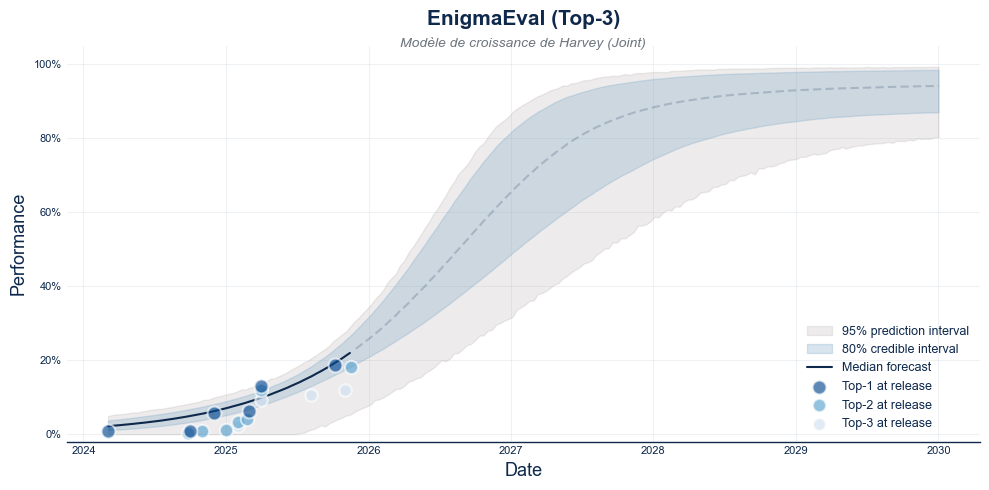

In [50]:
benchmark = "EnigmaEval"

plot_single_benchmark(
    task_name=benchmark,
    forecast_type="harvey_joint_hyperparameters_all",
    top_n=3,
    ci_level=80,
    show_prediction_interval=True,
    save_path=f"Images/beautiful_{benchmark}.png"
)

Saved plot to: Images/beautiful_comparison.png


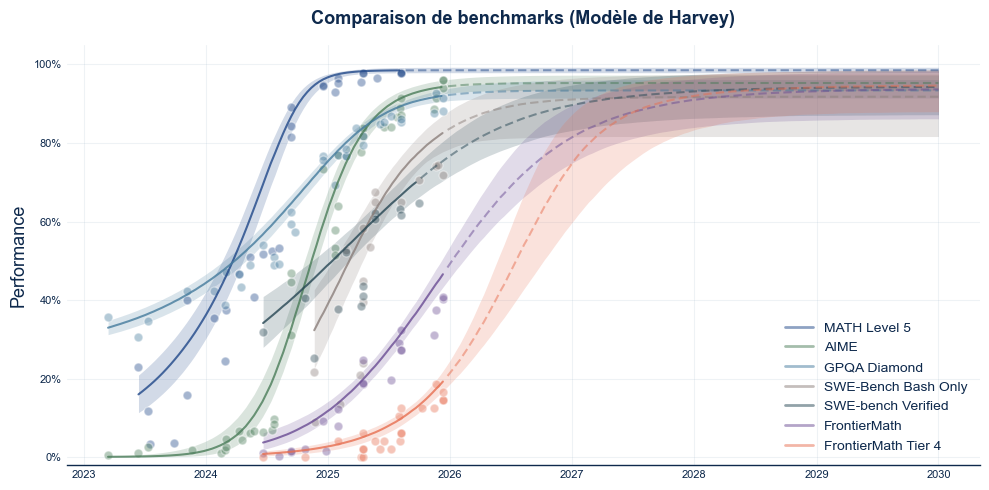

In [51]:
plot_benchmark_comparison(
    task_names=INTERNAL_BENCHMARKS,
    forecast_type="harvey_joint_hyperparameters_all",
    ci_level=80,
    save_path="Images/beautiful_comparison.png",
    figsize=(10, 5)
)

Saved plot to: Images/beautiful_grid.png


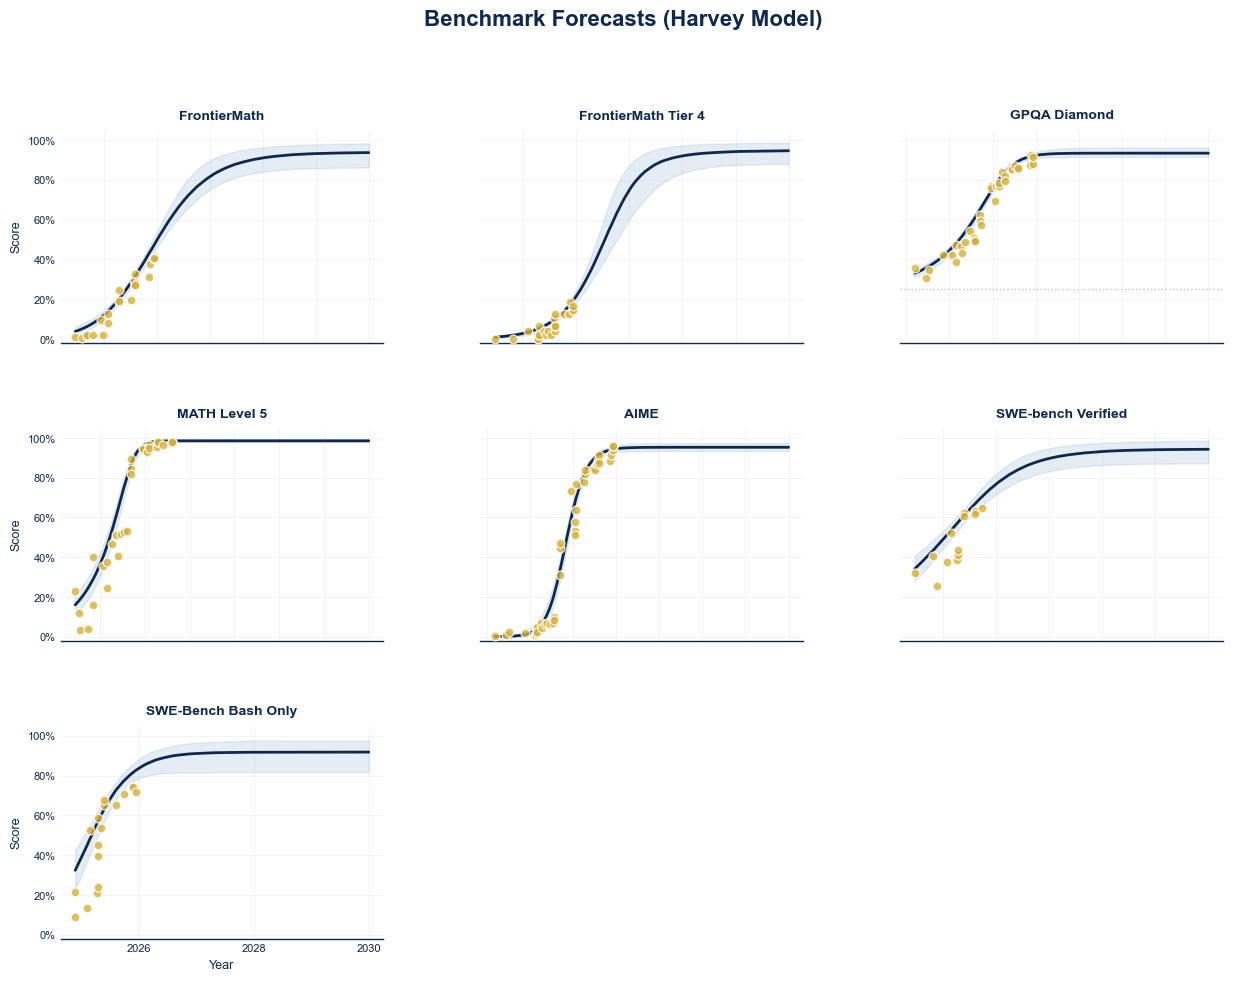

In [52]:
plot_benchmark_grid(
    task_names=INTERNAL_BENCHMARKS,
    forecast_type="harvey_joint_hyperparameters_all",
    ncols=3,
    subplot_size=(5, 3.5),
    save_path="Images/beautiful_grid.png"
)

## Plot by categories (partition by tiers + capabilities)


GENERATING CATEGORY PLOTS


----------------------------------------------------------------------
Category: Progrès vers l'AGI (Tier 3)
Benchmarks: 3
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier3_core_agi.png


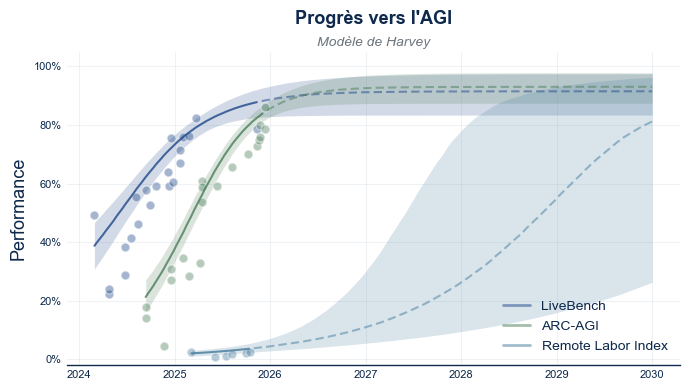

  ✅ Saved: Images/2-Categories/tier3_core_agi.png

----------------------------------------------------------------------
Category: Raisonnement Mathématique Avancé (Tier 3)
Benchmarks: 4
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier3_math.png


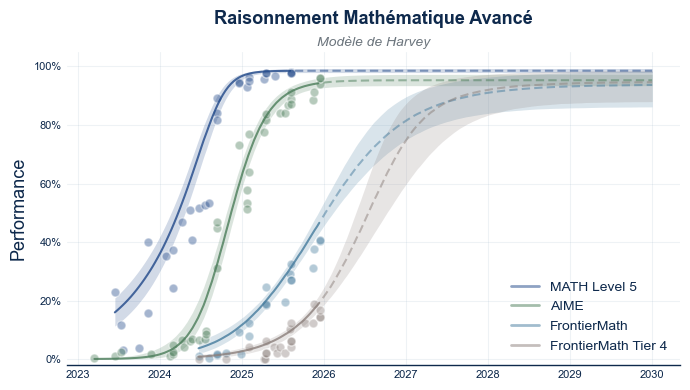

  ✅ Saved: Images/2-Categories/tier3_math.png

----------------------------------------------------------------------
Category: Ingénierie Logicielle Autonome (Tier 3)
Benchmarks: 7
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier3_engineering.png


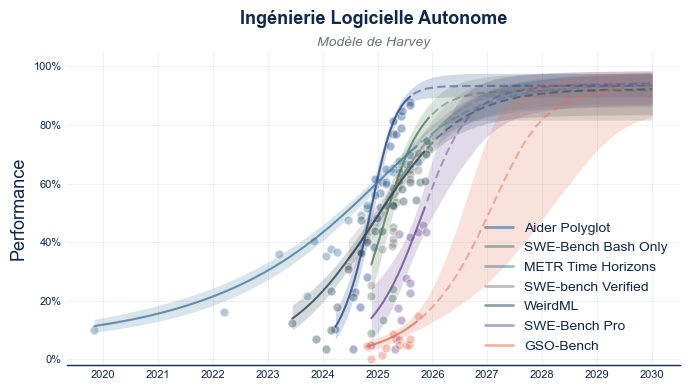

  ✅ Saved: Images/2-Categories/tier3_engineering.png

----------------------------------------------------------------------
Category: Opérations Agentiques sur Ordinateur (Tier 3)
Benchmarks: 6
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier3_computer_use.png


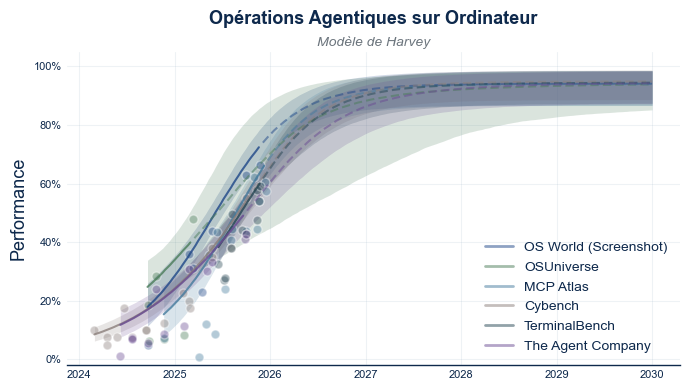

  ✅ Saved: Images/2-Categories/tier3_computer_use.png

----------------------------------------------------------------------
Category: Questions Spécialisées par Domaine (Tier 2)
Benchmarks: 7
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier2_domain_speficic.png


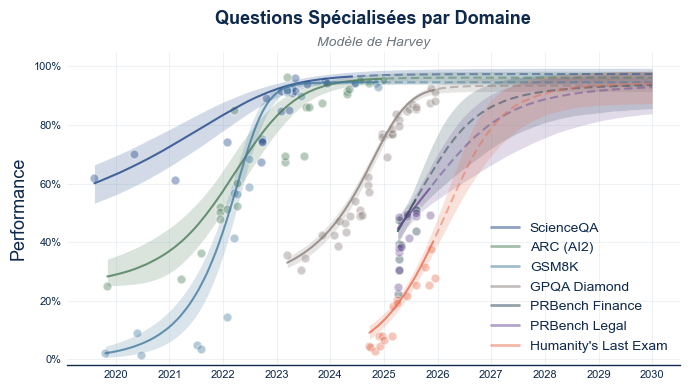

  ✅ Saved: Images/2-Categories/tier2_domain_speficic.png

----------------------------------------------------------------------
Category: Raisonnement Général (Tier 2)
Benchmarks: 5
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier2_reasoning.png


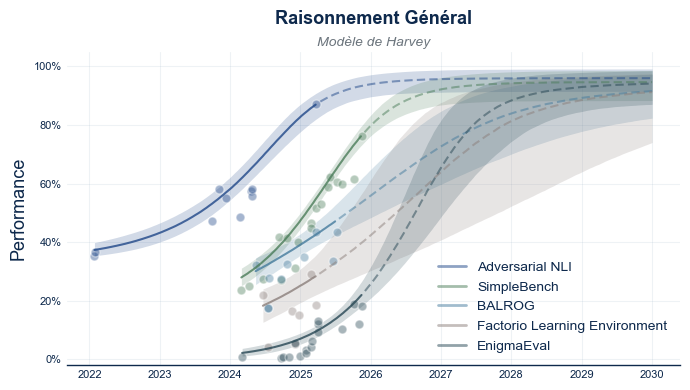

  ✅ Saved: Images/2-Categories/tier2_reasoning.png

----------------------------------------------------------------------
Category: Compréhension Multimodale (Tier 2)
Benchmarks: 6
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier2_multimodal.png


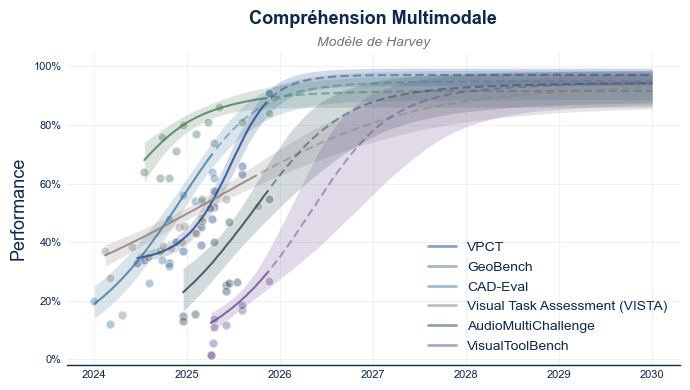

  ✅ Saved: Images/2-Categories/tier2_multimodal.png

----------------------------------------------------------------------
Category: Langage et Rédaction (Tier 2)
Benchmarks: 5
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier2_language.png


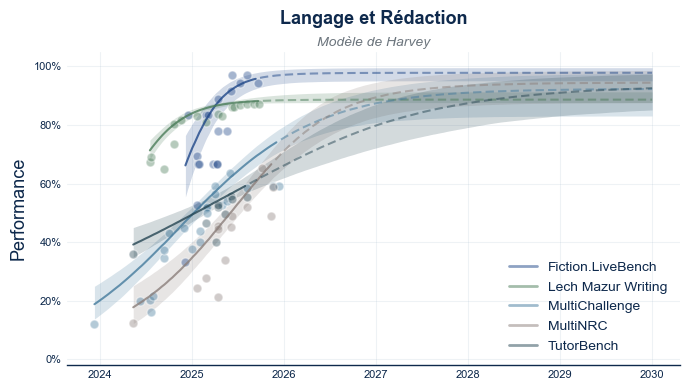

  ✅ Saved: Images/2-Categories/tier2_language.png

----------------------------------------------------------------------
Category: Sens Commun (Tier 1)
Benchmarks: 4
----------------------------------------------------------------------
Saved plot to: Images/2-Categories/tier1_commonsense.png


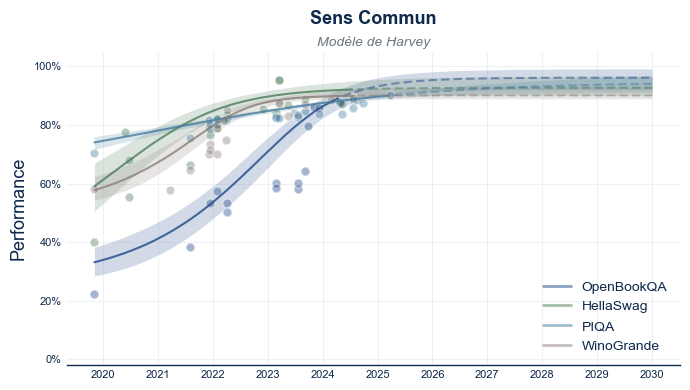

  ✅ Saved: Images/2-Categories/tier1_commonsense.png

SUMMARY
  ✅ Successful: 9/9
  ❌ Failed: 0/9
  📁 Output directory: Images/2-Categories



In [57]:
# ============================================================================
# PLOT ALL TIER/CAPABILITY CATEGORIES
# ============================================================================

# Define all categories with their metadata
CATEGORIES = {
    'tier3_core_agi': {
        'benchmarks': TIER3_CORE_AGI_PROGRESS,
        'name': 'Progrès vers l\'AGI',
        'tier': 3
    },
    'tier3_math': {
        'benchmarks': TIER3_HIGH_END_MATH_REASONING,
        'name': 'Raisonnement Mathématique Avancé',
        'tier': 3
    },
    'tier3_engineering': {
        'benchmarks': TIER3_AUTONOMOUS_SWE,
        'name': 'Ingénierie Logicielle Autonome',
        'tier': 3
    },
    'tier3_computer_use': {
        'benchmarks': TIER3_AGENTIC_COMPUTER_USE,
        'name': 'Opérations Agentiques sur Ordinateur',
        'tier': 3
    },
    'tier2_domain_speficic': {
        'benchmarks': TIER2_DOMAIN_SPECIFIC_QUESTIONS,
        'name': 'Questions Spécialisées par Domaine',
        'tier': 2
    },
    'tier2_reasoning': {
        'benchmarks': TIER2_GENERAL_REASONING,
        'name': 'Raisonnement Général',
        'tier': 2
    },
    'tier2_multimodal': {
        'benchmarks': TIER2_MULTIMODAL_UNDERSTANDING,
        'name': 'Compréhension Multimodale',
        'tier': 2
    },
    'tier2_language': {
        'benchmarks': TIER2_ADVANCED_LANGUAGE_AND_WRITING,
        'name': 'Langage et Rédaction',
        'tier': 2
    },
    'tier1_commonsense': {
        'benchmarks': TIER1_COMMONSENSE_QA,
        'name': 'Sens Commun',
        'tier': 1
    }
}

def plot_all_categories(forecast_type="harvey_joint_hyperparameters_all", 
                       top_n=3, 
                       ci_level=80,
                       output_dir="Images/Categories"):
    """
    Generate and save plots for all tier/capability categories.
    
    Args:
        forecast_type: type of forecast model
        top_n: number of top models
        ci_level: credible interval level
        output_dir: directory to save plots
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"GENERATING CATEGORY PLOTS")
    print(f"{'='*70}\n")
    
    # Track statistics
    successful = 0
    failed = 0
    
    for category_id, category_info in CATEGORIES.items():
        benchmarks = category_info['benchmarks']
        name = category_info['name']
        tier = category_info['tier']
        
        print(f"\n{'-'*70}")
        print(f"Category: {name} (Tier {tier})")
        print(f"Benchmarks: {len(benchmarks)}")
        print(f"{'-'*70}")
        
        # Skip if no benchmarks
        if not benchmarks:
            print(f"  ⚠️  No benchmarks in category, skipping...")
            continue
        
        try:
            # Generate filename
            safe_name = category_id.replace(' ', '_').replace('&', 'and')
            save_path = os.path.join(output_dir, f"{safe_name}.png")
            
            # Plot comparison with category metadata
            plot_benchmark_comparison(
                task_names=benchmarks,
                forecast_type=forecast_type,
                top_n=top_n,
                ci_level=ci_level,
                figsize=(7, 4),
                save_path=save_path,
                category_name=name  # Pass category name
            )
            
            print(f"  ✅ Saved: {save_path}")
            successful += 1
            
        except Exception as e:
            print(f"  ❌ Error: {e}")
            failed += 1
    
    # Summary
    print(f"\n{'='*70}")
    print(f"SUMMARY")
    print(f"{'='*70}")
    print(f"  ✅ Successful: {successful}/{len(CATEGORIES)}")
    print(f"  ❌ Failed: {failed}/{len(CATEGORIES)}")
    print(f"  📁 Output directory: {output_dir}")
    print(f"{'='*70}\n")

# Run the plotting function
plot_all_categories(
    forecast_type="harvey_joint_hyperparameters_all",
    top_n=3,
    ci_level=80,
    output_dir="Images/2-Categories"
)

## Harvey vs. Logistic

Found 48 benchmarks
Alpha range: [1.699, 6.014]
Median alpha: 2.915

Saved plot to: Images/1-Note-figures/Harvey_vs_logistic_shapes.png


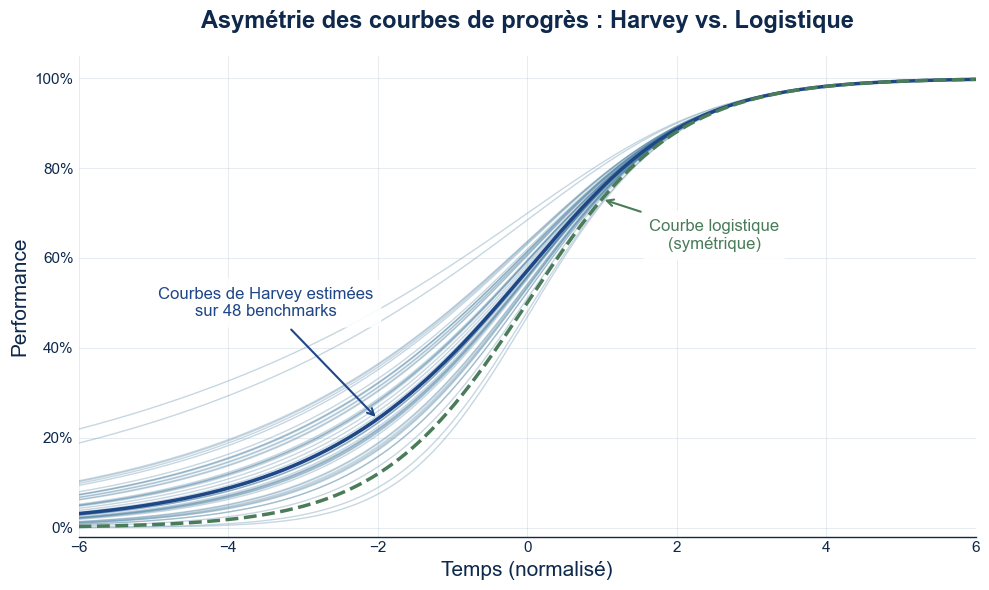


STATISTIQUES DES PARAMÈTRES α
  Min α:    1.699
  Max α:    6.014
  Médiane:  2.915
  Moyenne:  3.097
  Écart-type: 0.802

  Note: α > 0 indique une asymétrie avec
        croissance initiale plus lente


In [54]:
# ============================================================================
# ILLUSTRATIVE FIGURE: COMPARING HARVEY CURVE SHAPES VS LOGISTIC
# ============================================================================

def harvey_curve(t, alpha, k=1.0, t0=0.0):
    """
    Harvey growth curve normalized to [0, 1].
    
    Args:
        t: time array
        alpha: asymmetry parameter (alpha > 0 means slower early growth)
        k: growth rate (standardized to 1.0 for comparison)
        t0: inflection point (standardized to 0.0 for comparison)
    
    Returns:
        y values in [0, 1]
    """
    base = 1 - (1 - alpha) * np.exp(-k * (t - t0))
    return np.power(base, 1 / (1 - alpha))

def logistic_curve(t, k=1.0, t0=0.0):
    """
    Logistic curve normalized to [0, 1].
    
    Args:
        t: time array
        k: growth rate (standardized to 1.0 for comparison)
        t0: inflection point (standardized to 0.0 for comparison)
    
    Returns:
        y values in [0, 1]
    """
    return 1.0 / (1 + np.exp(-k * (t - t0)))

# Load all alpha values from the joint model
forecast_type = "harvey_joint_hyperparameters_all"
top_n = 3
load_dir = 'Fits'

# Load the joint model
idata_path = os.path.join(load_dir, f'joint_{forecast_type}_top{top_n}_idata.nc')
metadata_path = os.path.join(load_dir, f'joint_{forecast_type}_top{top_n}_metadata.pkl')

idata = az.from_netcdf(idata_path)
with open(metadata_path, 'rb') as f:
    metadata = pickle.load(f)

# Extract alpha samples for all benchmarks
# Shape: (chains, draws, n_benchmarks)
alpha_samples = idata.posterior['alpha'].values

# Get median alpha for each benchmark
n_benchmarks = alpha_samples.shape[-1]
median_alphas = np.median(alpha_samples.reshape(-1, n_benchmarks), axis=0)

print(f"Found {n_benchmarks} benchmarks")
print(f"Alpha range: [{median_alphas.min():.3f}, {median_alphas.max():.3f}]")
print(f"Median alpha: {np.median(median_alphas):.3f}")

# Create time grid centered on inflection point
t = np.linspace(-6, 6, 500)

# Create figure
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')

# Plot all Harvey curves with transparency
for i, alpha in enumerate(median_alphas):
    y = harvey_curve(t, alpha)
    ax.plot(t, y, color='#457b9d', alpha=0.3, linewidth=1.0, zorder=1)

# Plot median Harvey curve (bold)
median_alpha = np.median(median_alphas)
y_median = harvey_curve(t, median_alpha)
ax.plot(t, y_median, color='#1f4788', linewidth=2.5, zorder=3)

# Plot logistic reference (dashed)
y_logistic = logistic_curve(t)
ax.plot(t, y_logistic, color='#4a7c59', linewidth=2.5, linestyle='--', zorder=4)

# Add labels with arrows directly on curves
# Harvey curves label
harvey_label_x = -3.5
harvey_label_y = 0.5
ax.annotate(f'Courbes de Harvey estimées\nsur {n_benchmarks} benchmarks', 
            xy=(-2, harvey_curve(-2, median_alpha)), xytext=(harvey_label_x, harvey_label_y),
            fontsize=12, color='#1f4788', ha='center', va='center',
            arrowprops=dict(arrowstyle='->', color='#1f4788', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='none', alpha=0.9))

# Logistic curve label
logistic_label_x = 2.5
logistic_label_y = 0.65
ax.annotate('Courbe logistique\n(symétrique)', 
            xy=(1, logistic_curve(1)), xytext=(logistic_label_x, logistic_label_y),
            fontsize=12, color='#4a7c59', ha='center', va='center',
            arrowprops=dict(arrowstyle='->', color='#4a7c59', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='none', alpha=0.9))

# Formatting
ax.set_xlabel('Temps (normalisé)', fontsize=15, fontweight='500', color=BASE_COLOR)
ax.set_ylabel('Performance', fontsize=15, fontweight='500', color=BASE_COLOR)
ax.set_title('Asymétrie des courbes de progrès : Harvey vs. Logistique', 
             fontsize=17, fontweight='600', color=BASE_COLOR, pad=20)

# Grid and spines
ax.grid(True, alpha=0.15, linewidth=0.8, color=GRID_COLOR)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(BASE_COLOR)

# Format Y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax.tick_params(axis='y', left=False, right=False)
ax.tick_params(labelsize=11, colors=BASE_COLOR)
ax.tick_params(axis='x', labelsize=11, colors=BASE_COLOR)

# Axis limits
ax.set_xlim(-6, 6)
ax.set_ylim(-0.02, 1.05)

plt.tight_layout()

# Save
save_path = "Images/1-Note-figures/Harvey_vs_logistic_shapes.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='none', transparent=True)
print(f"\nSaved plot to: {save_path}")

plt.show()

# Print statistics
print(f"\n{'='*50}")
print("STATISTIQUES DES PARAMÈTRES α")
print(f"{'='*50}")
print(f"  Min α:    {median_alphas.min():.3f}")
print(f"  Max α:    {median_alphas.max():.3f}")
print(f"  Médiane:  {np.median(median_alphas):.3f}")
print(f"  Moyenne:  {np.mean(median_alphas):.3f}")
print(f"  Écart-type: {np.std(median_alphas):.3f}")
print(f"\n  Note: α > 0 indique une asymétrie avec")
print(f"        croissance initiale plus lente")
print(f"{'='*50}")

## Aymptotes

Found 48 benchmarks
Hyperparameters - μ_L: 0.939 ± 0.012
Hyperparameters - σ_L: 0.039 ± 0.011

Beta distribution parameters: α=34.96, β=2.25

INTERVALLES DE CRÉDIBILITÉ DE LA DISTRIBUTION DE POPULATION

Distribution Beta(α=34.96, β=2.25):
  Moyenne (μ_L): 0.939 (93.9%)
  Écart-type (σ_L): 0.039

Intervalle de crédibilité à 80%:
  [0.887, 0.981]
  [88.7%, 98.1%]
  Largeur: 0.094

Intervalle de crédibilité à 95%:
  [0.845, 0.991]
  [84.5%, 99.1%]
  Largeur: 0.146

Interprétation:
  80% des benchmarks ont une asymptote L entre 88.7% et 98.1%
  95% des benchmarks ont une asymptote L entre 84.5% et 99.1%

Probabilités a posteriori:
  P(L > 95%): 46.9%
  P(L > 90%): 85.3%
  P(L < 85%): 3.0%

Saved plot to: Images/1-Note-figures/Hierarchical_L_intervals.png


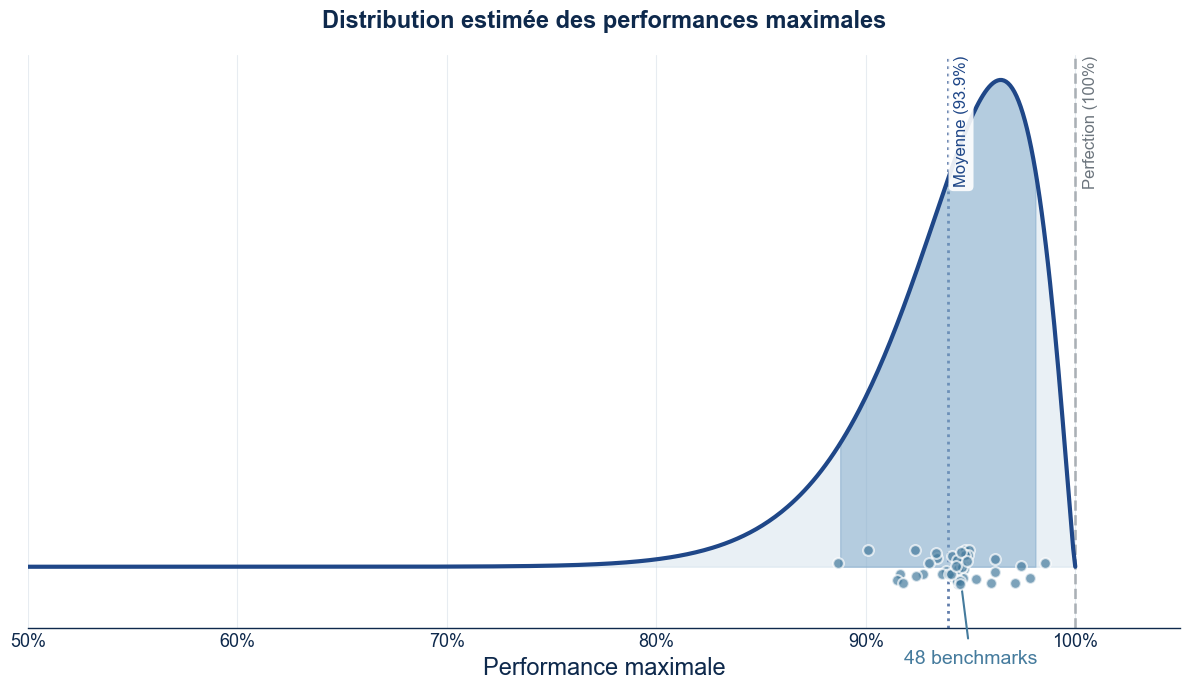

In [55]:
# ============================================================================
# ILLUSTRATIVE FIGURE: HIERARCHICAL DISTRIBUTION OF L (SIMPLIFIED)
# Show population-level Beta distribution + individual benchmark estimates
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load all L values from the joint model
forecast_type = "harvey_joint_hyperparameters_all"
top_n = 3
load_dir = 'Fits'

# Load the joint model
idata_path = os.path.join(load_dir, f'joint_{forecast_type}_top{top_n}_idata.nc')
metadata_path = os.path.join(load_dir, f'joint_{forecast_type}_top{top_n}_metadata.pkl')

idata = az.from_netcdf(idata_path)
with open(metadata_path, 'rb') as f:
    metadata = pickle.load(f)

# Extract hyperparameters for the hierarchical prior on L
# These define the population distribution
L_mu_samples = idata.posterior['L_mu'].values.flatten()
L_sigma_samples = idata.posterior['L_sigma'].values.flatten()

# Extract individual L samples for all benchmarks
L_samples = idata.posterior['L'].values  # Shape: (chains, draws, n_benchmarks)
n_benchmarks = L_samples.shape[-1]
L_flat = L_samples.reshape(-1, n_benchmarks)

# Get median L for each benchmark
median_L = np.median(L_flat, axis=0)

print(f"Found {n_benchmarks} benchmarks")
print(f"Hyperparameters - μ_L: {np.median(L_mu_samples):.3f} ± {np.std(L_mu_samples):.3f}")
print(f"Hyperparameters - σ_L: {np.median(L_sigma_samples):.3f} ± {np.std(L_sigma_samples):.3f}")

# ============================================================================
# Population-level distribution using median hyperparameters
# ============================================================================

# Create L grid
L_grid = np.linspace(0.5, 1.0, 500)

# Get median hyperparameters
median_mu = np.median(L_mu_samples)
median_sigma = np.median(L_sigma_samples)

# Convert (mu, sigma) to Beta distribution parameters (alpha, beta)
# For a truncated normal on [0, 1], we approximate with a Beta distribution
# Match mean and variance
# Beta mean: alpha / (alpha + beta) = mu
# Beta variance: (alpha * beta) / ((alpha + beta)^2 * (alpha + beta + 1)) = sigma^2

# Solve for alpha and beta
if median_sigma > 0:
    # Method of moments for Beta distribution
    variance = median_sigma**2
    
    # Ensure variance is valid for Beta distribution
    max_variance = median_mu * (1 - median_mu)
    if variance >= max_variance:
        variance = max_variance * 0.95  # Cap variance
    
    # Compute alpha and beta
    alpha = median_mu * (median_mu * (1 - median_mu) / variance - 1)
    beta = (1 - median_mu) * (median_mu * (1 - median_mu) / variance - 1)
    
    # Ensure positive parameters
    alpha = max(alpha, 0.5)
    beta = max(beta, 0.5)
else:
    # Degenerate case: point mass
    alpha = 100 * median_mu
    beta = 100 * (1 - median_mu)

print(f"\nBeta distribution parameters: α={alpha:.2f}, β={beta:.2f}")

# Compute Beta PDF
beta_dist = stats.beta(alpha, beta)
pdf_values = beta_dist.pdf(L_grid)

# ============================================================================
# CALCUL DES INTERVALLES DE CRÉDIBILITÉ POUR LA DISTRIBUTION DE POPULATION
# ============================================================================

# Using the Beta distribution with parameters already computed
print(f"\n{'='*60}")
print("INTERVALLES DE CRÉDIBILITÉ DE LA DISTRIBUTION DE POPULATION")
print(f"{'='*60}")

# Compute intervals from the Beta distribution
interval_80_lower = beta_dist.ppf(0.10)  # 10th percentile
interval_80_upper = beta_dist.ppf(0.90)  # 90th percentile
interval_95_lower = beta_dist.ppf(0.025) # 2.5th percentile
interval_95_upper = beta_dist.ppf(0.975) # 97.5th percentile

print(f"\nDistribution Beta(α={alpha:.2f}, β={beta:.2f}):")
print(f"  Moyenne (μ_L): {median_mu:.3f} ({median_mu:.1%})")
print(f"  Écart-type (σ_L): {median_sigma:.3f}")

print(f"\nIntervalle de crédibilité à 80%:")
print(f"  [{interval_80_lower:.3f}, {interval_80_upper:.3f}]")
print(f"  [{interval_80_lower:.1%}, {interval_80_upper:.1%}]")
print(f"  Largeur: {interval_80_upper - interval_80_lower:.3f}")

print(f"\nIntervalle de crédibilité à 95%:")
print(f"  [{interval_95_lower:.3f}, {interval_95_upper:.3f}]")
print(f"  [{interval_95_lower:.1%}, {interval_95_upper:.1%}]")
print(f"  Largeur: {interval_95_upper - interval_95_lower:.3f}")

print(f"\nInterprétation:")
print(f"  80% des benchmarks ont une asymptote L entre {interval_80_lower:.1%} et {interval_80_upper:.1%}")
print(f"  95% des benchmarks ont une asymptote L entre {interval_95_lower:.1%} et {interval_95_upper:.1%}")

# Calculate probability mass in key regions
prob_above_95 = 1 - beta_dist.cdf(0.95)
prob_above_90 = 1 - beta_dist.cdf(0.90)
prob_below_85 = beta_dist.cdf(0.85)

print(f"\nProbabilités a posteriori:")
print(f"  P(L > 95%): {prob_above_95:.1%}")
print(f"  P(L > 90%): {prob_above_90:.1%}")
print(f"  P(L < 85%): {prob_below_85:.1%}")

print(f"{'='*60}\n")

# ============================================================================
# VISUALISATION AVEC INTERVALLES
# ============================================================================

# Scale PDF for visualization (to match the height of the plot)
pdf_max = pdf_values.max()
scale_factor = 8.0  # Adjust this to control height of distribution curve
pdf_scaled = pdf_values / pdf_max * scale_factor

fig, ax = plt.subplots(figsize=(12, 7), facecolor='none')

# Plot population distribution
ax.plot(L_grid, pdf_scaled, color='#1f4788', linewidth=3, 
        zorder=3)

# Fill under curve
ax.fill_between(L_grid, 0, pdf_scaled, color='#b8cfe0', alpha=0.3, zorder=2)

# Highlight 80% interval
mask_80 = (L_grid >= interval_80_lower) & (L_grid <= interval_80_upper)
ax.fill_between(L_grid[mask_80], 0, pdf_scaled[mask_80], 
                color='#7fa8c9', alpha=0.5, zorder=2.5)

# Plot jittered points
np.random.seed(42)
jitter = np.random.uniform(-0.3, 0.3, size=n_benchmarks)
ax.scatter(median_L, jitter, s=60, color='#457b9d', 
          edgecolors='white', linewidth=1.5, alpha=0.7, zorder=4)

# Reference lines
ax.axvline(1.0, color=GRAY_COLOR, linestyle='--', linewidth=2, alpha=0.5, zorder=1)
ax.text(1.011, ax.get_ylim()[1], 'Perfection (100%)', 
       fontsize=12, color=GRAY_COLOR, ha='right', va='top', rotation=90)

ax.axvline(median_mu, color='#1f4788', linestyle=':', linewidth=2, alpha=0.7, zorder=2)
ax.text(median_mu+0.006, ax.get_ylim()[1], f'Moyenne ({median_mu:.1%})',
       fontsize=12, color='#1f4788', ha='center', va='top', rotation=90,
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='none', alpha=0.9))

# Label for benchmark points
points_center = np.median(median_L)
ax.annotate(f'{n_benchmarks} benchmarks', 
            xy=(points_center, 0),
            xytext=(0.95, -1.5),
            fontsize=14, color='#457b9d', ha='center', va='center',
            arrowprops=dict(arrowstyle='->', color='#457b9d', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor='none', alpha=0.9))

# Formatting
ax.set_xlabel('Performance maximale', fontsize=17, fontweight='500', color=BASE_COLOR)
ax.set_ylabel('', fontsize=17, fontweight='500', color=BASE_COLOR)
ax.set_title('Distribution estimée des performances maximales', 
            fontsize=17, fontweight='600', color=BASE_COLOR, pad=20)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
ax.tick_params(axis='x', labelsize=13, colors=BASE_COLOR)
ax.set_yticks([])
ax.tick_params(axis='y', left=False, right=False)

ax.grid(True, alpha=0.15, linewidth=0.8, color=GRID_COLOR, axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(BASE_COLOR)

ax.set_xlim(0.5, 1.05)
ax.set_ylim(-1, ax.get_ylim()[1])

plt.tight_layout()

save_path = "Images/1-Note-figures/Hierarchical_L_intervals.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='none', transparent=True)
print(f"Saved plot to: {save_path}")

plt.show()

## Proportion of saturated benchmarks


COMPUTING: Proportion of benchmarks > 95% of L by 2030-01-01

Loaded 48 benchmarks
Posterior samples: 8000 (4 chains × 2000 draws)

Computed predictions for all benchmarks at 2030-01-01

RESULTS: Proportion of benchmarks > 95% of L by 2030-01-01
  Mean:   95.5%
  Median: 95.8%
  Std:    2.8%
  80% CI: [91.7%, 97.9%]
  95% CI: [89.6%, 100.0%]

Saved plot to: Images/1-Note-figures/Posterior_proportion_benchmarks_above_95pct_of_L_by_2030.png


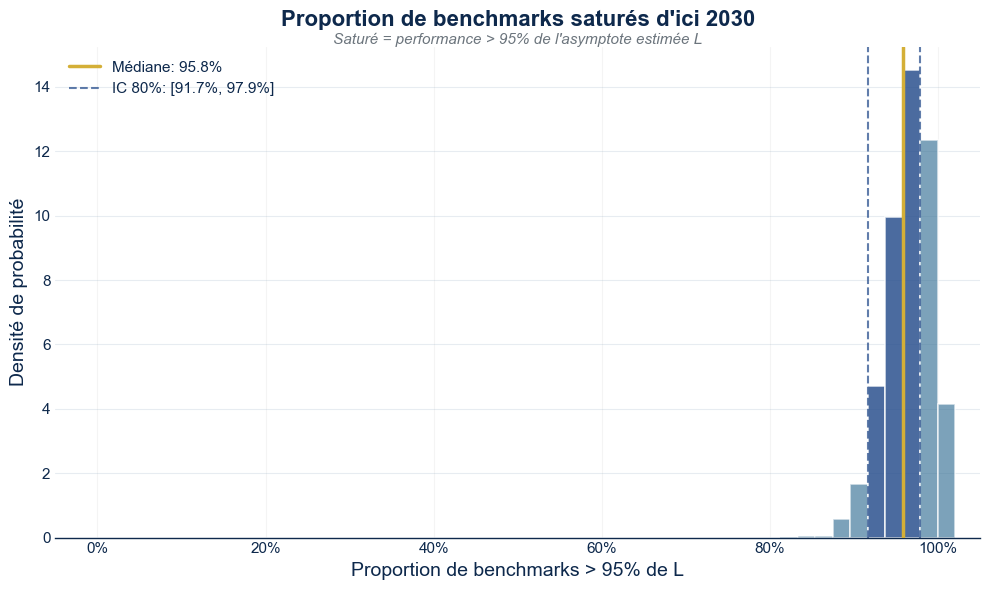


BENCHMARK-LEVEL PROBABILITIES (> 95% of L by 2030-01-01)

Benchmarks most likely to exceed 95% of L:
  OpenBookQA                               : 100.0%  (L≈96.2%, seuil≈92.6%)
  Cybench                                  : 100.0%  (L≈94.9%, seuil≈90.1%)
  METR Time Horizons                       : 100.0%  (L≈93.7%, seuil≈89.2%)
  LiveBench                                : 100.0%  (L≈91.5%, seuil≈86.9%)
  Lech Mazur Writing                       : 100.0%  (L≈88.7%, seuil≈84.2%)
  HellaSwag                                : 100.0%  (L≈92.7%, seuil≈89.4%)
  GSM8K                                    : 100.0%  (L≈94.6%, seuil≈89.9%)
  GeoBench                                 : 100.0%  (L≈91.6%, seuil≈87.1%)
  Fiction.LiveBench                        : 100.0%  (L≈97.8%, seuil≈92.9%)
  CAD-Eval                                 : 100.0%  (L≈94.9%, seuil≈90.2%)

Benchmarks least likely to exceed 95% of L:
  Visual Task Assessment (VISTA)           : 96.6%  (L≈94.1%, seuil≈89.4%)
  PRBench Finance 

In [ ]:
# ============================================================================
# POSTERIOR DISTRIBUTION: PROPORTION OF BENCHMARKS > 95% OF L BY 2030
# ============================================================================

# Configuration
saturation_fraction = 0.95  # Consider saturated when reaching 95% of L
target_date = date(2030, 1, 1)
forecast_type = "harvey_joint_hyperparameters_all"
top_n = 3

print(f"\n{'='*70}")
print(f"COMPUTING: Proportion of benchmarks > {saturation_fraction:.0%} of L by {target_date}")
print(f"{'='*70}\n")

# Load joint model
idata_path = os.path.join('Fits', f'joint_{forecast_type}_top{top_n}_idata.nc')
metadata_path = os.path.join('Fits', f'joint_{forecast_type}_top{top_n}_metadata.pkl')

idata = az.from_netcdf(idata_path)
with open(metadata_path, 'rb') as f:
    metadata = pickle.load(f)

task_names = metadata['task_names']
n_benchmarks = len(task_names)

print(f"Loaded {n_benchmarks} benchmarks")

# Extract posterior samples
posterior = idata.posterior
n_chains = posterior.sizes['chain']
n_draws = posterior.sizes['draw']
n_samples = n_chains * n_draws

print(f"Posterior samples: {n_samples} ({n_chains} chains × {n_draws} draws)")

# For each benchmark, compute prediction at 2030 and threshold for all posterior samples
curve_01_2030 = np.zeros((n_samples, n_benchmarks))

for task_idx, task_name in enumerate(task_names):
    # Load frontier data to get time reference
    safe_task_name = task_name.replace('/', '_').replace(' ', '_').replace('.', '_')
    frontier_csv_path = os.path.join('Fits', f'{safe_task_name}_{forecast_type}_top{top_n}_frontier.csv')
    frontier_df = pd.read_csv(frontier_csv_path)
    frontier_df['date'] = pd.to_datetime(frontier_df['date']).dt.date
    
    # Get lower bound
    lower_bound = LOWER_BOUNDS_DICT.get(task_name, 0.0)
    
    # Calculate days from first observation to 2030
    min_date = frontier_df['date'].min()
    t_2030 = (target_date - min_date).days
    
    # Extract parameters for this benchmark
    k_samples = posterior['k'].sel(k_dim_0=task_idx).values.flatten()
    t0_samples = posterior['t0'].sel(t0_dim_0=task_idx).values.flatten()
    alpha_samples = posterior['alpha'].sel(alpha_dim_0=task_idx).values.flatten()
    
    # Compute Harvey curve at t_2030 for all samples
    exponent = -k_samples * (t_2030 - t0_samples)
    base = 1 - (1 - alpha_samples) * np.exp(exponent)
    curve_01 = np.power(base, 1 / (1 - alpha_samples))
    
    # Compute predictions
    curve_01_2030[:, task_idx] = curve_01

print(f"\nComputed predictions for all benchmarks at {target_date}")

# Compute proportion of benchmarks exceeding their respective threshold for each posterior sample
# Compare each prediction to its corresponding threshold (varies per sample)
above_threshold = curve_01_2030 > saturation_fraction
proportion_above_threshold = above_threshold.sum(axis=1) / n_benchmarks

# Statistics
mean_prop = proportion_above_threshold.mean()
median_prop = np.median(proportion_above_threshold)
std_prop = proportion_above_threshold.std()
ci_80_prop = np.percentile(proportion_above_threshold, [10, 90])
ci_95_prop = np.percentile(proportion_above_threshold, [2.5, 97.5])

print(f"\n{'='*70}")
print(f"RESULTS: Proportion of benchmarks > {saturation_fraction:.0%} of L by {target_date}")
print(f"{'='*70}")
print(f"  Mean:   {mean_prop:.1%}")
print(f"  Median: {median_prop:.1%}")
print(f"  Std:    {std_prop:.1%}")
print(f"  80% CI: [{ci_80_prop[0]:.1%}, {ci_80_prop[1]:.1%}]")
print(f"  95% CI: [{ci_95_prop[0]:.1%}, {ci_95_prop[1]:.1%}]")
print(f"{'='*70}\n")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')

# Histogram with proportions on x-axis
# Use bins aligned to data range for complete coverage
counts, bin_edges, patches = ax.hist(proportion_above_threshold, 
                                      color='#457b9d', alpha=0.7, 
                                      edgecolor='white', linewidth=1.2,
                                      density=True, bins=np.arange(0, 1.05, 1/n_benchmarks))

# Color bars inside 80% CI differently
for i, (count, patch) in enumerate(zip(counts, patches)):
    bin_center = (bin_edges[i] + bin_edges[i+1]) / 2
    if ci_80_prop[0] <= bin_center <= ci_80_prop[1]:
        patch.set_facecolor('#1f4788')
        patch.set_alpha(0.8)

# Add vertical lines for statistics
ax.axvline(median_prop, color='#d4af37', linewidth=2.5, linestyle='-', 
           label=f'Médiane: {median_prop:.1%}', zorder=5)
ax.axvline(ci_80_prop[0], color='#1f4788', linewidth=1.5, linestyle='--', alpha=0.7)
ax.axvline(ci_80_prop[1], color='#1f4788', linewidth=1.5, linestyle='--', alpha=0.7,
           label=f'IC 80%: [{ci_80_prop[0]:.1%}, {ci_80_prop[1]:.1%}]')

# Formatting
ax.set_xlabel(f'Proportion de benchmarks > {saturation_fraction:.0%} de L', fontsize=14, 
              fontweight='500', color=BASE_COLOR)
ax.set_ylabel('Densité de probabilité', fontsize=14, fontweight='500', color=BASE_COLOR)
ax.set_title(f'Proportion de benchmarks saturés d\'ici {target_date.year}', 
             fontsize=16, fontweight='600', color=BASE_COLOR, pad=15)

# Subtitle explaining the threshold
ax.text(0.5, 1.0, f'Saturé = performance > {saturation_fraction:.0%} de l\'asymptote estimée L',
        transform=ax.transAxes, ha='center', va='bottom',
        fontsize=11, color=GRAY_COLOR, style='italic')

# Grid and spines
ax.grid(True, alpha=0.15, linewidth=0.8, color=GRID_COLOR, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color(BASE_COLOR)

ax.tick_params(axis='y', left=False, right=False)
ax.tick_params(labelsize=11, colors=BASE_COLOR)

# X-axis formatting as percentage
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
ax.set_xlim(-0.05, 1.05)

# Legend
legend = ax.legend(loc='upper left', fontsize=11, framealpha=0.95,
                   edgecolor=BASE_COLOR, fancybox=True)
for text in legend.get_texts():
    text.set_color(BASE_COLOR)

plt.tight_layout()

# Save
save_path = f"Images/1-Note-figures/Posterior_proportion_benchmarks_above_{int(saturation_fraction*100)}pct_of_L_by_2030.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='none', transparent=True)
print(f"Saved plot to: {save_path}")

plt.show()

# ============================================================================
# BENCHMARK-LEVEL PROBABILITIES
# ============================================================================

print(f"\n{'='*70}")
print(f"BENCHMARK-LEVEL PROBABILITIES (> {saturation_fraction:.0%} of L by {target_date})")
print(f"{'='*70}\n")

# Compute probability for each benchmark (proportion of samples where prediction > threshold)
prob_above = above_threshold.mean(axis=0)

# Sort by probability
sorted_indices = np.argsort(prob_above)[::-1]

print(f"Benchmarks most likely to exceed {saturation_fraction:.0%} of L:")
for i in sorted_indices[:10]:
    median_L = np.median(posterior['L'].sel(L_dim_0=i).values)
    median_threshold = LOWER_BOUNDS_DICT.get(task_names[i], 0.0) + saturation_fraction * (median_L - LOWER_BOUNDS_DICT.get(task_names[i], 0.0))
    print(f"  {task_names[i]:<40} : {prob_above[i]:.1%}  (L≈{median_L:.1%}, seuil≈{median_threshold:.1%})")

print(f"\nBenchmarks least likely to exceed {saturation_fraction:.0%} of L:")
for i in sorted_indices[-10:]:
    median_L = np.median(posterior['L'].sel(L_dim_0=i).values)
    median_threshold = LOWER_BOUNDS_DICT.get(task_names[i], 0.0) + saturation_fraction * (median_L - LOWER_BOUNDS_DICT.get(task_names[i], 0.0))
    print(f"  {task_names[i]:<40} : {prob_above[i]:.1%}  (L≈{median_L:.1%}, seuil≈{median_threshold:.1%})")

print(f"\n{'='*70}\n")